# 1. Data
We're going to approach the problem of classifying points on a graph into 2 groups (a binary classification problem). To create the data, we'll use `sklearn`.

In [ ]:
# @title Generate data

from sklearn.datasets import make_circles

num_samples = 1000

X, y = make_circles(num_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
# @title Make DataFrame

import pandas as pd

circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})

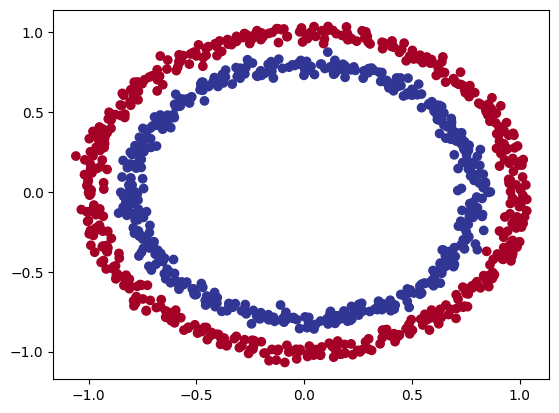

In [ ]:
# @title Visualise, visualise, visualise!

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)  # Colour map is Red-Yellow-Blue

In [ ]:
# @title Convert data to Tensors

import torch

X = torch.from_numpy(X).type(torch.float32) # To convert from float64 numpy array to float32 Tensor
y = torch.from_numpy(y).type(torch.float32)

In [ ]:
# @title Split into train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# 2. Build a classification model
The steps to building a DL model remain the same:
1. Make device agnostic code
2. Constructing an architecture using `nn.Module`
3. Making our training and testing loops (this includes selecting a loss function and an optimiser)

In [ ]:
# @title Let's write some device agnostic code

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {}".format(device))

Using cpu


This model will:
1. Subclass `nn.Module`, like all classes.
2. Have 2 FC layers, capable of handling the input and output shapes of `X` and `y`.
3. Define a `forward()` method for inputs.

In [ ]:
# @title Building the model!

class ClassificationModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer_1 = nn.Linear(in_features=2, out_features=5)  # The input features are X, and outputs 5 features
    self.linear_layer_2 = nn.Linear(in_features=5, out_features=1)  # The input features are the 5 previously generated features, output feature is y

    # # We could also use nn.Sequential() instead
    # self.two_linear_layers = nn.Sequential(
    #     nn.Linear(in_features=2, out_features=5),
    #     nn.Linear(in_features=5, out_features=1)
    # )

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_2(self.linear_layer_1(X))
    # return self.two_linear_layers(X)

# Instantiate the model (and send it to the target device)
model_0 = ClassificationModelV0()
model_0.to(device)

ClassificationModelV0(
  (linear_layer_1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**Note**: We could use `nn.Sequential` to build the model architecture, and in our simple example, it'll work just fine: building the 2 linear layers with the correct input and output sizes, and making sure our forward pass works by *sequentially* passing the input from the first to the second layer.

However, `nn.Sequential` is not sufficient to capture more complicated networks where a simple sequential architecture is not enough. There, it's best to define a model class like we have been doing.

Of course, `nn.Sequential` can still be used to define *parts* of those more complicated networks.

# 3. Train and test

In [ ]:
# @title Choosing loss function and optimiser

loss_fn = nn.BCEWithLogitsLoss()  # Binary cross entropy loss (w/ logits) is good for binary classification tasks

optimiser = torch.optim.SGD(params=model_0.parameters(),
                         lr=0.1)  # Using SGD cos it's a classic

**Note**: The classification model's outputs are *raw logits*, and can be converted to predicted probabilities, which can then be converted to predicted classes.

We can convert the raw logits to probabilities using an **activation function**. For binary classification, this may be `nn.Sigmoid()`; for multi-class classification, this may be `nn.Softmax()`.

Then, we can convert the probabilites to classes by **rounding** or taking the `argmax()`.

**Note**:
1. The sigmoid function, used for binary classification, ensures that the unbounded model outputs are forced into the range [0,1] and add up to 1 (like regular probabilites).
2. The softmax function, used for multi-class classification, has a similar purpose as the sigmoid, except that it takes the model outputs and ensures that the probabilites for *all classes* (which are more than 2) lie between [0,1] and add up to 1.

In [ ]:
# @title Making a function to calculate accuracy

def find_accuracy(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Making the training and testing loop
The steps to make a training loop remain the same:
0. Set the model to training mode
1. Forward pass
2. Calculate loss
3. Zero grad
4. Backpropogate
5. Update optimiser

And, to test:
0. Set the model to testing mode
1. Forward pass
2. Calculate loss

In [ ]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)

for epoch in range(epochs):
  ## Training
  # 0. Put model in training mode
  model_0.train()

  # 1. Forward pass
  y_pred = model_0(X_train).squeeze() # y_pred are logits!

  # 2. Calculate loss (and accuracy)
  loss = loss_fn(y_pred, y_train)  # BCEWithLogitsLoss() takes logits as input, so we're directly inputting y_pred
  # loss = loss_without_logits(torch.round(nn.Sigmoid(y_pred))) # If we use BCE w/o logits, we'd need to convert the logits to classes
  y_pred_classes = torch.round(torch.sigmoid(y_pred))
  accuracy = find_accuracy(y_pred_classes, y_train)

  # 3. Zero grad
  optimiser.zero_grad()

  # 4. Backpropogate
  loss.backward()

  # 5. Update optimiser
  optimiser.step()

  ## Testing
  # 0. Set model to testing mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test).squeeze()

    # 2. Calculate loss (and accuracy)
    test_loss = loss_fn(test_pred, y_test)
    y_pred_classes = torch.round(torch.sigmoid(test_pred))
    test_accuracy = find_accuracy(y_pred_classes, y_test)

  if epoch % 10 == 0:
    print("Epoch: {} | Train loss: {} | Train accuracy: {}% | Test loss: {} | Test accuracy: {}%".format(epoch, loss, accuracy, test_loss, test_accuracy))

Epoch: 0 | Train loss: 0.6929798722267151 | Train accuracy: 51.125% | Test loss: 0.6946565508842468 | Test accuracy: 46.0%
Epoch: 10 | Train loss: 0.6929798722267151 | Train accuracy: 51.125% | Test loss: 0.694657564163208 | Test accuracy: 46.0%
Epoch: 20 | Train loss: 0.6929799914360046 | Train accuracy: 51.125% | Test loss: 0.6946585774421692 | Test accuracy: 45.5%
Epoch: 30 | Train loss: 0.6929799914360046 | Train accuracy: 51.125% | Test loss: 0.6946595907211304 | Test accuracy: 45.5%
Epoch: 40 | Train loss: 0.6929799914360046 | Train accuracy: 51.125% | Test loss: 0.6946604251861572 | Test accuracy: 45.5%
Epoch: 50 | Train loss: 0.6929798722267151 | Train accuracy: 51.125% | Test loss: 0.6946612000465393 | Test accuracy: 45.5%
Epoch: 60 | Train loss: 0.6929798722267151 | Train accuracy: 51.125% | Test loss: 0.6946619153022766 | Test accuracy: 45.5%
Epoch: 70 | Train loss: 0.6929798722267151 | Train accuracy: 51.125% | Test loss: 0.6946626305580139 | Test accuracy: 45.5%
Epoch: 80 

## Visualising our results
I'm just gonna copy-paste this whole thing from Daniel Bourke's course. Point is, we want to visualise our **decision boundary**, and to do this we'll download some helper functions from Bourke's course GitHub repo.

In [ ]:
# @title Importing helper functions

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

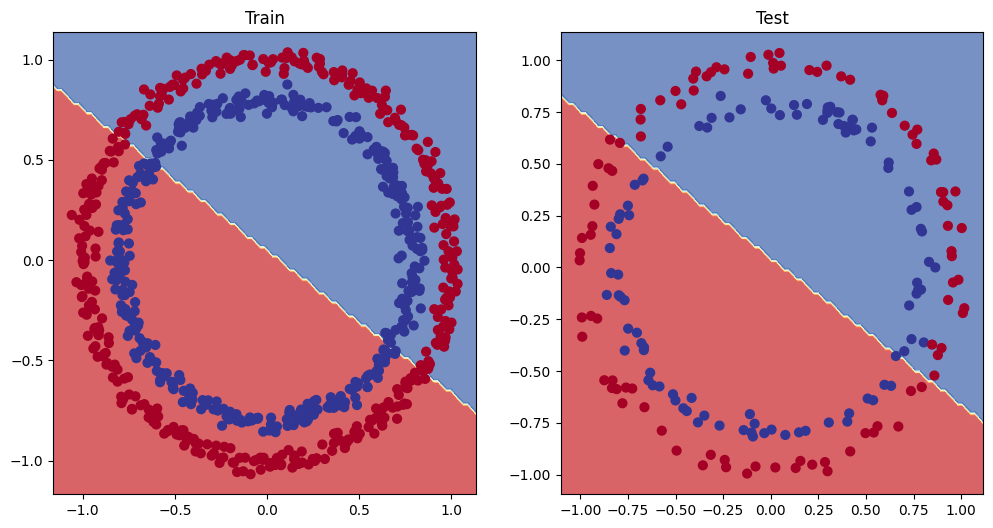

In [ ]:
# @title Plotting our generated decision boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 4. How to improve a model
This model, with 2 linear layers, no activation layer, SGD optimiser, etc. isn't doing a good job at separating the two circles. Some **hyperparameters** we can change to improve its performance are:
1. Adding more layers
2. Adding more hidden units (nodes)
3. Training for more epochs
4. Changing the activation function(s)
5. Changing the learning rate
6. Changing the loss function
7. Using transfer learning

I'm going to add a ReLU activation layer and change the optimiser to `nn.Adam`.

In [ ]:
# @title Building a better model

class ClassificationModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # Let's add more layers and hidden units
    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=1)

        # I added the below 4 layers cos I thought they would be necessary, but the above 3 were enough to get good results
        # nn.ReLU(),
        # nn.Linear(in_features=64, out_features=8),
        # nn.ReLU(),
        # nn.Linear(in_features=8, out_features=1)
    )

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.layers(X)

model_1 = ClassificationModelV1()
model_1.to(device)

ClassificationModelV1(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:
# @title Choose a loss function and optimiser

loss_fn = nn.BCEWithLogitsLoss()

# Let's choose Adam this time
optimiser = torch.optim.Adam(params=model_1.parameters(),
                          lr=0.1)

In [ ]:
# @title Training (and testing) time!

# I'll just copy-paste the old training+testing loop (we should make this whole thing a function later)
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)

for epoch in range(epochs):
  ## Training
  # 0. Put model in training mode
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train).squeeze()

  # 2. Calculate loss (and accuracy)
  loss = loss_fn(y_pred, y_train)
  y_pred_classes = torch.round(torch.sigmoid(y_pred))
  accuracy = find_accuracy(y_pred_classes, y_train)

  # 3. Zero grad
  optimiser.zero_grad()

  # 4. Backpropogate
  loss.backward()

  # 5. Update optimiser
  optimiser.step()

  ## Testing
  # 0. Set model to testing mode
  model_1.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_1(X_test).squeeze()

    # 2. Calculate loss (and accuracy)
    test_loss = loss_fn(test_pred, y_test)
    y_pred_classes = torch.round(torch.sigmoid(test_pred))
    test_accuracy = find_accuracy(y_pred_classes, y_test)

  if epoch % 10 == 0:
    print("Epoch: {} | Train loss: {} | Train accuracy: {}% | Test loss: {} | Test accuracy: {}%".format(epoch, loss, accuracy, test_loss, test_accuracy))

Epoch: 0 | Train loss: 0.6973499059677124 | Train accuracy: 48.75% | Test loss: 0.6915863156318665 | Test accuracy: 50.0%
Epoch: 10 | Train loss: 0.6388649940490723 | Train accuracy: 80.375% | Test loss: 0.6388930678367615 | Test accuracy: 70.5%
Epoch: 20 | Train loss: 0.5039022564888 | Train accuracy: 92.0% | Test loss: 0.5144743323326111 | Test accuracy: 93.5%
Epoch: 30 | Train loss: 0.3275917172431946 | Train accuracy: 99.625% | Test loss: 0.3442170023918152 | Test accuracy: 98.0%
Epoch: 40 | Train loss: 0.19494330883026123 | Train accuracy: 99.375% | Test loss: 0.22731594741344452 | Test accuracy: 98.5%
Epoch: 50 | Train loss: 0.12573200464248657 | Train accuracy: 99.5% | Test loss: 0.15519045293331146 | Test accuracy: 98.0%
Epoch: 60 | Train loss: 0.08740701526403427 | Train accuracy: 99.375% | Test loss: 0.11988397687673569 | Test accuracy: 98.5%
Epoch: 70 | Train loss: 0.06340542435646057 | Train accuracy: 99.875% | Test loss: 0.09413159638643265 | Test accuracy: 98.5%
Epoch: 80

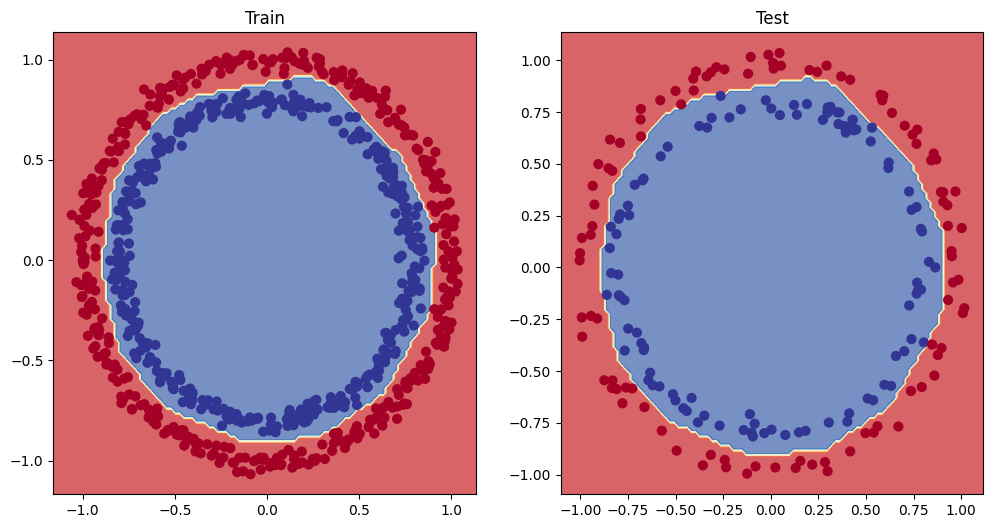

In [ ]:
# @title Let's visualise the predictions from our improved model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# 5. Putting it all together
Let's try out what we've worked on with a multiclass classification problem. For this, we'll need to:
1. Make our dataset; we'll use `sklearn.datasets.make_blobs()`, which will make clusters of points.
2. Build our model, and
3. Train and test the model.

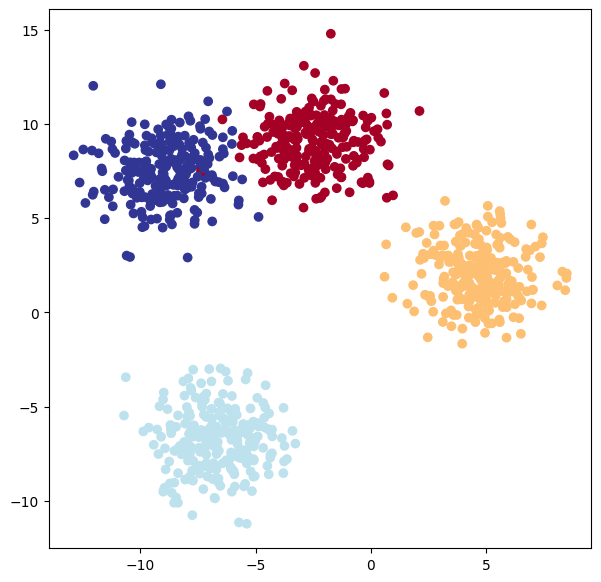

In [ ]:
# @title Generating multiclass data

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2  # We only have 2 features, the x and y coordinates
RANDOM_SEED = 42

# 1. Create data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,  # number of X features
                            centers=NUM_CLASSES,  # number of y labels
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Train-test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Visualise, visualise, visualise
plt.figure(figsize=(7, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
# @title Selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# @title Defining the model

from torch import nn

class MultiClassModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        # nn.ReLU(),  # <- We actually don't really need ReLU for this! The decision boundaries and accuracies turn out to be pretty similar with and without ReLU.
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    out = self.layers(x)
    return out

In [ ]:
# @title Instantiating the model

NUM_CLASSES = 4
NUM_FEATURES = 2  # We only have 2 features, the x and y coordinates

model_4 = MultiClassModel(NUM_FEATURES, NUM_CLASSES, 8).to(device)
model_4

MultiClassModel(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# @title Selecting loss function and optimiser

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [ ]:
# @title Getting predictions from untrained model

model_4.eval()

with torch.inference_mode():
  out = model_4(X_blob_train)

out.shape

torch.Size([800, 4])

In [ ]:
x = 100.00123
print(f"a: {x: .2f}")

a:  100.00


In [ ]:
# @title Training and testing loop

torch.manual_seed(42)

epochs = 100

# Put all Tensors to target device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ## Training
  # 0. Set to training mode
  model_4.train()

  # 1. Forward pass
  output_logits = model_4(X_blob_train)

  # 2. Calculate loss (and accuracy)
  loss = loss_fn(output_logits, y_blob_train) # nn.CrossEntropyLoss() also takes logits and target (indices)
  output_probabilities = torch.softmax(output_logits, dim=1)
  output_classes = torch.argmax(output_probabilities, dim=1)
  accuracy = find_accuracy(output_classes, y_blob_train)

  # 3. Optimiser zero grad
  optimiser.zero_grad()

  # 4. Backprop
  loss.backward()

  # 5. Optimiser step
  optimiser.step()

  ## Testing
  # 0. Set to eval mode
  model_4.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_output_logits = model_4(X_blob_test)
    test_output_prob = torch.softmax(test_output_logits, dim=1)
    test_output_classes = torch.argmax(test_output_prob, dim=1)

    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_output_logits, y_blob_test)
    test_accuracy = find_accuracy(test_output_classes, y_blob_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train loss: {loss: .5f}, Train accuracy: {accuracy: .2f}%, Test loss: {test_loss: .5f}, Test accuracy: {test_accuracy: .2f}%")

Epoch: 0, Train loss:  1.04324, Train accuracy:  65.50%, Test loss:  0.57861, Test accuracy:  95.50%
Epoch: 10, Train loss:  0.14398, Train accuracy:  99.12%, Test loss:  0.13037, Test accuracy:  99.00%
Epoch: 20, Train loss:  0.08062, Train accuracy:  99.12%, Test loss:  0.07216, Test accuracy:  99.50%
Epoch: 30, Train loss:  0.05924, Train accuracy:  99.12%, Test loss:  0.05133, Test accuracy:  99.50%
Epoch: 40, Train loss:  0.04892, Train accuracy:  99.00%, Test loss:  0.04098, Test accuracy:  99.50%
Epoch: 50, Train loss:  0.04295, Train accuracy:  99.00%, Test loss:  0.03486, Test accuracy:  99.50%
Epoch: 60, Train loss:  0.03910, Train accuracy:  99.00%, Test loss:  0.03083, Test accuracy:  99.50%
Epoch: 70, Train loss:  0.03643, Train accuracy:  99.00%, Test loss:  0.02799, Test accuracy:  99.50%
Epoch: 80, Train loss:  0.03448, Train accuracy:  99.00%, Test loss:  0.02587, Test accuracy:  99.50%
Epoch: 90, Train loss:  0.03300, Train accuracy:  99.12%, Test loss:  0.02423, Test

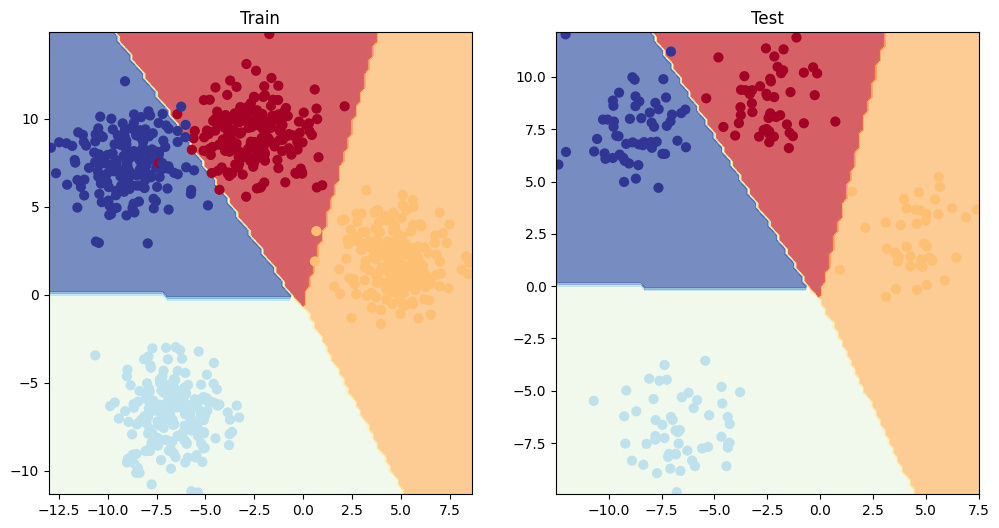

In [ ]:
# @title Plot predictions

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)